In [1]:
# import numpy
import numpy as np

# load up arm parameters arm_params and some helper functions
from twojointarm_funs import *

# for plotting
import matplotlib.pyplot as plt

In [2]:
# Setup initial conditions of simulation

A0    = np.array([45,90]) * np.pi/180  # arm mid-movement position: (45,90) degrees (shoulder,elbow)
H0,E0 = joints_to_hand(A0, arm_params) # convert to cartesian (x,y) hand position H1
mt    = 0.400                          # movement time (sec)
sr    = 100                            # sample rate (Hz)
movdist = 0.15                         # total movement distance (m)
npts  = int(mt*sr)+1                   # number of time points

In [3]:
n       = 8         # number of targets around the circle
angs    = np.linspace(0,2*np.pi,n+1)[0:-1]

In [4]:
# initialize arrays to store torques, hand paths, and joint angles
HH = np.zeros((npts,2,n)) # hand position (m)

In [5]:
# compute min-jerk trajectory and muscle torques using inverse dynamics for each target
TGT0 = H0
TGTS = np.zeros((2,n))
for i, a in enumerate(angs):
    sincos = np.array([np.cos(a), np.sin(a)])
    H1 = H0 + movdist * sincos
    TGTS[:,i] = H1
    t,H,Hd,Hdd = minjerk(H0,H1,mt,npts)
    A,Ad,Add = hand_to_joints((H,Hd,Hdd),arm_params)
    Q = inverse_dynamics(A,Ad,Add,arm_params)
    HH[:,:,i] = H


In [13]:
def plot_hand_paths(TGTS0,TGTS,H):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.plot(TGT0[0],TGT0[1], 'ro', markersize=20, markerfacecolor='none')
    for i,a in enumerate(angs):
        ax.plot(TGTS[0,i],TGTS[1,i], 'ro', markersize=10, markerfacecolor='none')
        ax.plot(H[:,0,i],H[:,1,i],'b.', markersize=3)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('HAND PATH')
    fig.tight_layout()

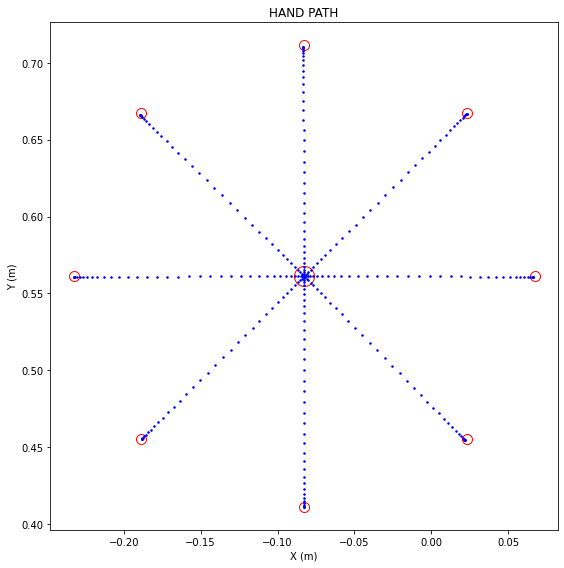

In [14]:
# Simulate movements in NF
b = 8
FF_NF  = np.array([[0, 0],[ 0,0]])
FF_CCW = np.array([[0,-b],[ b,0]])
FF_CW  = np.array([[0, b],[-b,0]])

arm_params['FF'] = FF_NF

H_NF = np.zeros((npts,2,n)) # hand paths
QQ   = np.zeros((npts,2,n)) # muscle torques
for i,a in enumerate(angs):
    t,H,Hd,Hdd = minjerk(H0,TGTS[:,i],mt,npts)
    A,Ad,Add = hand_to_joints((H,Hd,Hdd),arm_params)
    Q = inverse_dynamics(A,Ad,Add,arm_params)
    A0,Ad0 = A[0,:],np.zeros((1,2))
    A_sim, Ad_sim, Add_sim = forward_dynamics(A0, Ad0, Q, t, arm_params)
    H_sim,_ = joints_to_hand(A_sim, arm_params)
    H_NF[:,:,i] = H_sim
plot_hand_paths(TGT0,TGTS,H_NF)

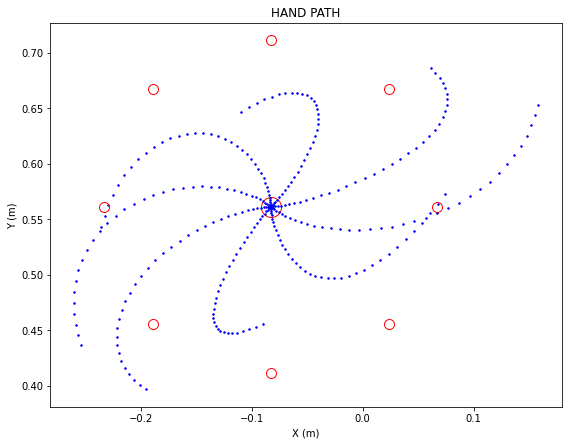

In [15]:
# Simulate movements in CWFF
b = 8
FF_NF  = np.array([[0, 0],[ 0,0]])
FF_CCW = np.array([[0,-b],[ b,0]])
FF_CW  = np.array([[0, b],[-b,0]])

H_NF = np.zeros((npts,2,n)) # hand paths
QQ   = np.zeros((npts,2,n)) # muscle torques
for i,a in enumerate(angs):
    t,H,Hd,Hdd = minjerk(H0,TGTS[:,i],mt,npts)
    A,Ad,Add = hand_to_joints((H,Hd,Hdd),arm_params)
    arm_params['FF'] = FF_NF # compute muscle torques needed for a NF
    Q = inverse_dynamics(A,Ad,Add,arm_params)
    A0,Ad0 = A[0,:],np.zeros((1,2))
    arm_params['FF'] = FF_CW # run the simulation forward using a CWFF
    A_sim, Ad_sim, Add_sim = forward_dynamics(A0, Ad0, Q, t, arm_params)
    H_sim,_ = joints_to_hand(A_sim, arm_params)
    H_NF[:,:,i] = H_sim
plot_hand_paths(TGT0,TGTS,H_NF)